Epoch    1 | total 5.365e-01 | phys 1.434e-04 | ic_u 5.254e-01 | ic_ut 8.555e-03 | bc 2.383e-03
Epoch  500 | total 2.527e-02 | phys 1.458e-03 | ic_u 6.403e-03 | ic_ut 1.015e-03 | bc 1.640e-02
Epoch 1000 | total 1.901e-03 | phys 4.364e-04 | ic_u 1.453e-04 | ic_ut 9.119e-05 | bc 1.228e-03
Epoch 1500 | total 3.440e-04 | phys 6.527e-05 | ic_u 4.113e-05 | ic_ut 4.909e-05 | bc 1.885e-04
Epoch 2000 | total 3.116e-04 | phys 1.307e-04 | ic_u 3.057e-05 | ic_ut 3.900e-05 | bc 1.113e-04
Epoch 2500 | total 5.222e-04 | phys 3.485e-04 | ic_u 1.486e-05 | ic_ut 6.966e-05 | bc 8.913e-05
Epoch 3000 | total 8.519e-04 | phys 6.094e-04 | ic_u 1.457e-05 | ic_ut 1.222e-04 | bc 1.057e-04
Epoch 3500 | total 3.672e-04 | phys 2.309e-04 | ic_u 1.023e-05 | ic_ut 8.297e-05 | bc 4.303e-05
Epoch 4000 | total 1.510e-04 | phys 6.590e-05 | ic_u 6.167e-06 | ic_ut 4.195e-05 | bc 3.700e-05


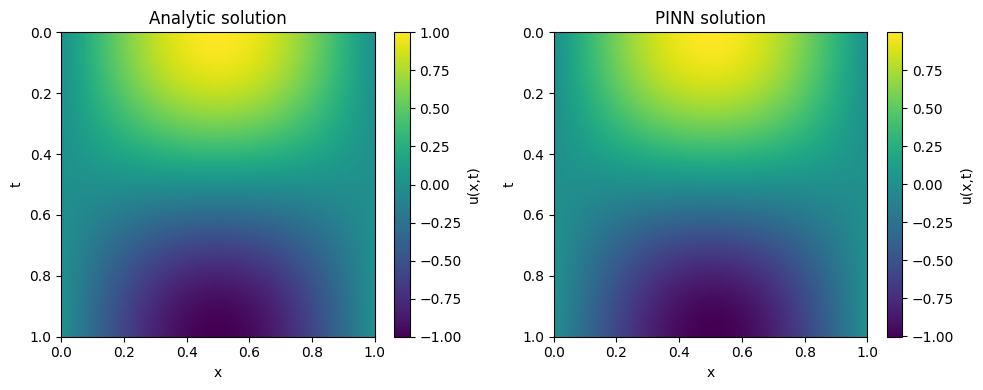

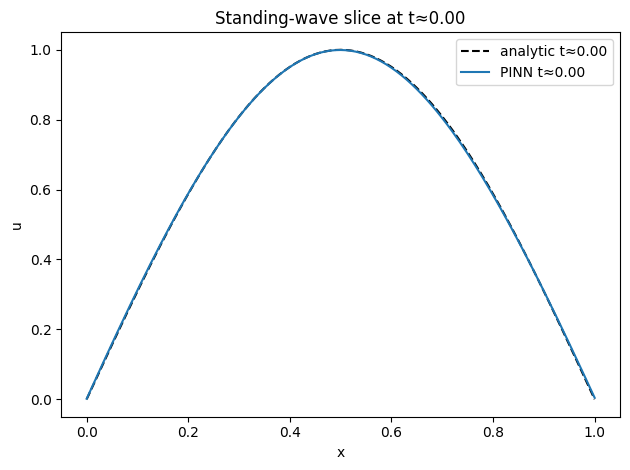

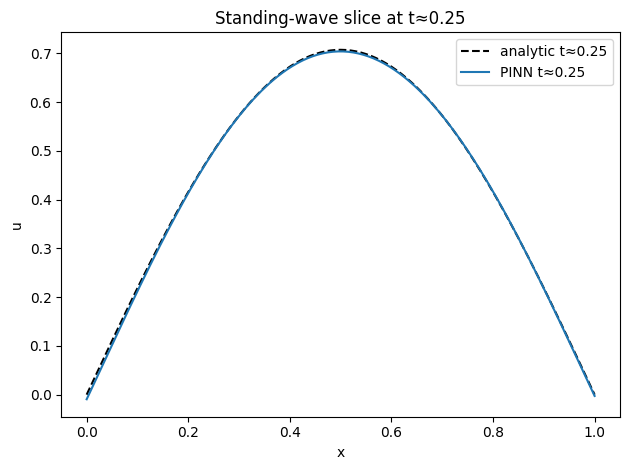

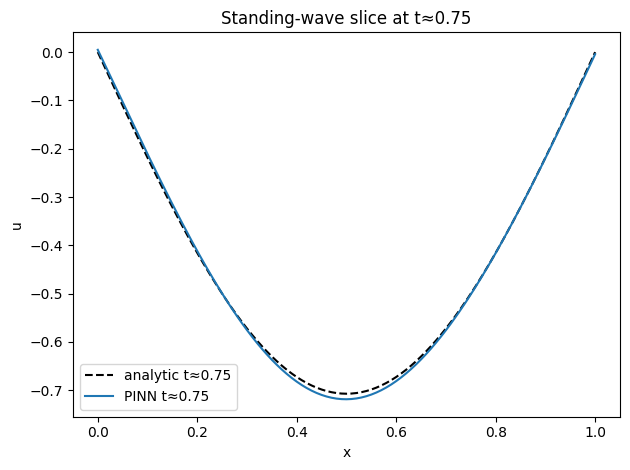

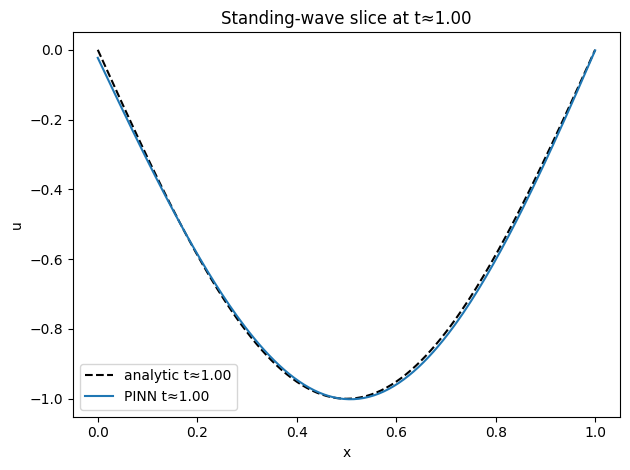

In [6]:
# %% PINN for 1D wave equation on a fixed string: u_tt = c^2 u_xx
#    Forward mode (known c) or inverse mode (learn c or mu)
import math, numpy as np
import torch, torch.nn as nn
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float32)

# ----------------------------
# Problem setup
# ----------------------------
L = 1.0                      # string length
T0, T1 = 0.0, 1.0            # time window
# Choose one of these:
MODE = "forward_c"           # "forward_c", "infer_c", or "infer_mu"

# Physics parameters
c_true = 1.0                 # used in forward and as 'truth'
TENSION = 100.0              # N, only used when MODE=="infer_mu"
# (If infer_mu) we will learn mu such that c = sqrt(TENSION/mu)

# Training/sample sizes
N_COL = 6000                 # collocation points (physics residual)
N_ICx = 400                  # initial condition points for u(x,0)
N_ICt = 400                  # initial condition points for ut(x,0)
N_BC  = 400                  # boundary points at x=0 and x=L over time
EPOCHS = 4000                # training epochs
LR = 1e-3                    # learning rate (step size).

SEED = 7
torch.manual_seed(SEED); np.random.seed(SEED)

# ----------------------------
# Network u_theta(x,t)
# ----------------------------
class MLP(nn.Module):
    def __init__(self, width=64, depth=5):
        super().__init__()
        layers = [nn.Linear(2, width), nn.Tanh()]
        for _ in range(depth-2):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight); nn.init.zeros_(m.bias)
    def forward(self, xt):
        return self.net(xt)

model = MLP(width=64, depth=5).to(DEVICE)

# Parameters to learn (for inverse tasks)
params = list(model.parameters())
if MODE == "infer_c":
    log_c = nn.Parameter(torch.log(torch.tensor([0.8], device=DEVICE)))
    params += [log_c]
elif MODE == "infer_mu":
    log_mu = nn.Parameter(torch.log(torch.tensor([0.01], device=DEVICE)))  # initial guess
    params += [log_mu]

opt = torch.optim.Adam(params, lr=LR)

# ----------------------------
# Analytic solution
# ----------------------------
def analytic_solution(xs, ts, c_val):
    """
    Analytic solution for:
      u_tt = c^2 u_xx
      u(x,0) = sin(pi x / L), u_t(x,0) = 0
    => u(x,t) = sin(pi x / L) * cos(c*pi*t / L)
    xs: (nx,) array
    ts: (nt,) array
    returns: (nt, nx) array U_true
    """
    X, T = np.meshgrid(xs, ts)
    U_true = np.sin(np.pi * X / L) * np.cos(c_val * np.pi * T / L)
    return U_true

# ----------------------------
# Sampling utilities
# ----------------------------
def sample_collocation(n):
    x = np.random.uniform(0.0, L, (n,1))
    t = np.random.uniform(T0, T1, (n,1))
    XT = torch.tensor(np.hstack([x,t]), dtype=torch.float32, device=DEVICE, requires_grad=True)
    return XT

def sample_ic_u(n):
    # u(x,0) = sin(pi x/L)
    x = np.random.uniform(0.0, L, (n,1))
    t = np.zeros_like(x)
    u0 = np.sin(np.pi * x / L)
    XT = torch.tensor(np.hstack([x,t]), dtype=torch.float32, device=DEVICE)
    U0 = torch.tensor(u0, dtype=torch.float32, device=DEVICE)
    return XT, U0

def sample_ic_ut(n):
    # u_t(x,0) = 0
    x = np.random.uniform(0.0, L, (n,1))
    t = np.zeros_like(x)
    XT = torch.tensor(np.hstack([x,t]), dtype=torch.float32, device=DEVICE, requires_grad=True)
    UT0 = torch.zeros((n,1), dtype=torch.float32, device=DEVICE)
    return XT, UT0

def sample_bc(n):
    # u(0,t)=0 and u(L,t)=0 for random t
    t1 = np.random.uniform(T0, T1, (n//2,1))
    t2 = np.random.uniform(T0, T1, (n - n//2,1))
    X1 = np.zeros_like(t1)
    X2 = L*np.ones_like(t2)
    XT = np.vstack([np.hstack([X1,t1]), np.hstack([X2,t2])])
    UT = np.zeros((XT.shape[0],1))
    XT = torch.tensor(XT, dtype=torch.float32, device=DEVICE)
    UT = torch.tensor(UT, dtype=torch.float32, device=DEVICE)
    return XT, UT

XT_col = sample_collocation(N_COL)
XT_ic_u, U_ic = sample_ic_u(N_ICx)
XT_ic_ut, UT_ic = sample_ic_ut(N_ICt)
XT_bc, U_bc = sample_bc(N_BC)

# ----------------------------
# Autodiff helpers
# ----------------------------
def d( y, x ):
    return torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True, retain_graph=True)[0]

def pde_residual(model, XT, c_val):
    """ r = u_tt - c^2 u_xx  (we drive r -> 0) """
    u = model(XT)
    grads = d(u, XT)           # [du/dx, du/dt]
    u_x = grads[:,0:1]; u_t = grads[:,1:2]
    u_xx = d(u_x, XT)[:,0:1]
    u_tt = d(u_t, XT)[:,1:2]
    return u_tt - (c_val**2) * u_xx

# ----------------------------
# Training loop
# ----------------------------
def train():
    for epoch in range(1, EPOCHS+1):
        opt.zero_grad()

        # Current wave speed
        if MODE == "forward_c":
            c_val = torch.tensor([c_true], device=DEVICE)
        elif MODE == "infer_c":
            c_val = torch.exp(log_c)
        elif MODE == "infer_mu":
            mu = torch.exp(log_mu)
            c_val = torch.sqrt(torch.tensor([TENSION], device=DEVICE)/mu)

        # Physics loss
        r = pde_residual(model, XT_col, c_val)
        loss_phys = torch.mean(r**2)

        # IC: displacement
        u_ic_pred = model(XT_ic_u)
        loss_ic_u = torch.mean((u_ic_pred - U_ic)**2)

        # IC: velocity
        u_ic_ut = model(XT_ic_ut)
        u_t_ic = d(u_ic_ut, XT_ic_ut)[:,1:2]
        loss_ic_ut = torch.mean((u_t_ic - UT_ic)**2)

        # BC: fixed ends
        u_bc_pred = model(XT_bc)
        loss_bc = torch.mean((u_bc_pred - U_bc)**2)

        loss = loss_phys + loss_ic_u + loss_ic_ut + loss_bc
        loss.backward(); opt.step()

        if epoch % 500 == 0 or epoch == 1:
            msg = (f"Epoch {epoch:4d} | total {loss.item():.3e} | "
                   f"phys {loss_phys.item():.3e} | ic_u {loss_ic_u.item():.3e} | "
                   f"ic_ut {loss_ic_ut.item():.3e} | bc {loss_bc.item():.3e}")
            if MODE == "infer_c":
                msg += f" | c≈{c_val.item():.4f}"
            if MODE == "infer_mu":
                msg += f" | mu≈{mu.item():.5f} | c≈{c_val.item():.4f}"
            print(msg)

train()

# ----------------------------
# Visualization
# ----------------------------
@torch.no_grad()
def predict_grid(nx=201, nt=201):
    xs = np.linspace(0.0, L, nx)
    ts = np.linspace(T0, T1, nt)
    XX, TT = np.meshgrid(xs, ts)
    XT = torch.tensor(np.stack([XX.ravel(), TT.ravel()], axis=1),
                      dtype=torch.float32, device=DEVICE)
    UU_pinn = model(XT).cpu().numpy().reshape(nt, nx)

    # Analytic solution using c_true
    UU_true = analytic_solution(xs, ts, c_true)
    return xs, ts, UU_pinn, UU_true

xs, ts, UU_pinn, UU_true = predict_grid()

# --- Heatmap comparison ---
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(UU_true, extent=[xs.min(), xs.max(), ts.max(), ts.min()],
           aspect='auto', origin='upper')
plt.colorbar(label='u(x,t)')
plt.xlabel('x'); plt.ylabel('t'); plt.title('Analytic solution')

plt.subplot(1,2,2)
plt.imshow(UU_pinn, extent=[xs.min(), xs.max(), ts.max(), ts.min()],
           aspect='auto', origin='upper')
plt.colorbar(label='u(x,t)')
plt.xlabel('x'); plt.ylabel('t'); plt.title('PINN solution')

plt.tight_layout(); plt.show()

# --- Time slices: PINN vs analytic ---
for t_show in [0.0, 0.25, 0.75, 1.0]:
    ti = np.argmin(np.abs(ts - t_show))
    plt.plot(xs, UU_true[ti], 'k--', label=f"analytic t≈{ts[ti]:.2f}")
    plt.plot(xs, UU_pinn[ti], label=f"PINN t≈{ts[ti]:.2f}")
    plt.xlabel('x'); plt.ylabel('u')
    plt.title(f'Standing-wave slice at t≈{ts[ti]:.2f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
